<a href="https://colab.research.google.com/github/khushbooekhande/DrugRecommendationSystem/blob/master/DrugSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install pandasql

In [0]:
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd 
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import to_categorical
from tensorflow.keras import layers
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandasql as ps

In [8]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Extract the reviews and ratings from the merged data file and make an array list of all the reviews
2. Map the values of rating into postive and negative with threshold >7

In [0]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(f'/content/drive/My Drive/New_Dataset/Merged_Dataset.csv')
df = df[['Review', 'Rating', 'Drug']]
review = list(df.Review)
labels = np.where(df['Rating']>7, 1, 0)

Checking the review and ratings for few 

In [10]:
for i in range (0, 5):
    print("Review: ", review[i])
    print("Label 1 for Postive and 0 for negative: ", labels[i])
    print('\n')

Review:  "No side effects,  easy to take, no more symptoms since taking."
Label 1 for Postive and 0 for negative:  1


Review:  "I&#039;ve been taking this medicine for a little over 6 months.
I am a 66 yr. old female.  In 2014, I lost 30 pds. on purpose, so I have been feeling good, except age-related pain in my hip joints.
I&#039;ve just realized recently that I&#039;m no longer feeling pain in my joints. Nothing has changed in my life except the addition of this medicine.

So...I&#039;ve concluded this is a POSITIVE side effect from taking this medicine."
Label 1 for Postive and 0 for negative:  1


Review:  "I took ibuprofen (2 caps at night for severe back pain) while taking this medicine and woke in the morning with a severe nose bleed."
Label 1 for Postive and 0 for negative:  0


Review:  "After my VAD Stroke I am on plavix.  I have a toddler that I still nurse. I looked up plavix for several days &amp; talked to several doctors. Some said it was fine, some said it was not ok. 

Defining a function for getting CV and tfID vectors for review analysis

In [0]:
def _tfIDV(list_review):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(list_review)
    X = X.toarray()
    return X

Using the defined function get the tfID vectors and categorical label encoding

In [0]:
data = _tfIDV(review)
labels = to_categorical(labels, num_classes=2)
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22, shuffle=False)

In [13]:
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Creating a Simple Neural Network using keras API

In [0]:
def _createModel():
    model = tf.keras.Sequential()
    model.add(layers.Dense(25, input_shape=(x_train.shape[1],)))
    model.add(layers.BatchNormalization(momentum=0.8))    
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(25))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(25))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(2, activation='softmax'))   
    model.summary()
    return model 

Compiling the model with binary_crossentropy loss function and optimizing with adam optimizer

In [15]:
model = _createModel()
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])
hist = model.fit(
    x_train, y_train,
    epochs= 10,
    batch_size = 100,
    validation_data = (x_test, y_test))
print("Avg. Val_Accuracy from sklearn_CV:", np.mean(hist.history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                315550    
_________________________________________________________________
batch_normalization (BatchNo (None, 25)                100       
_________________________________________________________________
activation (Activation)      (None, 25)                0         
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
activation_1 (Activation)    (None, 25)                0

Visualizing training loss and accuracy

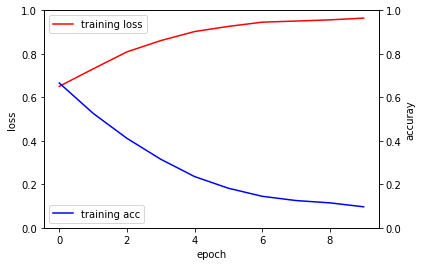

In [16]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['accuracy'], 'r', label='training loss')
acc_ax.plot(hist.history['loss'], 'b', label='training acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

Evaluating model performance with scoring metrics

In [17]:
scores = model.evaluate(x_test, y_test, verbose=0)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
score = precision_recall_fscore_support(y_true, y_pred, average='macro')
print("Evaluation metrics for Sentiment Analysis: ", '\n', "Loss: ", scores[0], '\n'
     , "Accuracy: ", scores[1], '\n', "F1_Score: ", score[2], '\n', "Precision: ", score[0], '\n', 
     "Recall: ", score[1])

Evaluation metrics for Sentiment Analysis:  
 Loss:  0.9126712679862976 
 Accuracy:  0.6744532585144043 
 F1_Score:  0.671237155245684 
 Precision:  0.6889432709281142 
 Recall:  0.6788620218849556


In [0]:
def _posneg(x):
    if x == 0:
        return 'negative'
    if x == 1:
        return 'positive'

Viewing some of the reviews with actual and predicted values

In [19]:
preds = model.predict(x_test[0:5])
preds = np.argmax(preds, axis=1)
y_test = np.argmax(y_test[0:5], axis=1)
d = {'reviews':[review[8048],review[8049],review[8050],review[8051],
               review[8052]], 'actual label': [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]], 
    'predicted label': [preds[0], preds[1], preds[2], preds[3], preds[4]]}
table = pd.DataFrame(data=d)
tableA = table['actual label'].apply(_posneg)
tableP = table['predicted label'].apply(_posneg)
table = table['reviews']
res = pd.concat([table, tableA, tableP], axis=1, sort=False)
print("Some of the reviews and sentiments using w2v embedding")
print('\n')
print(res)
print('\n')

Some of the reviews and sentiments using w2v embedding


                                             reviews actual label  \
0  "I am taking Diamox this is the 3rd time I hav...     positive   
1                               "Works good for me."     negative   
2  "I&#039;ve had glaucoma since I was 9, and I&#...     positive   
3  "I have Iritis, so to get rid of the inflamati...     negative   
4  "It helped lower my pressure but made my eyes ...     negative   

  predicted label  
0        negative  
1        positive  
2        positive  
3        negative  
4        negative  




In [0]:
def _posneg1(x):
    if x == 0:
        return 'negative'
    if x == 1:
        return 'positive'

In [21]:
preds = model.predict(data)
preds = np.argmax(preds, axis=1)
d = {'Review':review[:], 
    'predicted_label': preds[:]}
table = pd.DataFrame(data=d)
tableP = table['predicted_label'].apply(_posneg1)
table = table['Review']
res = pd.concat([table, tableP], axis=1, sort=False)
print('\n')
print(res)
print('\n')



                                                  Review predicted_label
0      "No side effects,  easy to take, no more sympt...        positive
1      "I&#039;ve been taking this medicine for a lit...        positive
2      "I took ibuprofen (2 caps at night for severe ...        negative
3      "After my VAD Stroke I am on plavix.  I have a...        negative
4      "No side effects,  easy to take, no more sympt...        positive
...                                                  ...             ...
10055  "Reminds me of Adderall but only a natural way...        negative
10056  "My husband has Vascular Dementia for appox. 4...        negative
10057  "I&#039;ve only been using this medication (pa...        negative
10058                               "Makes me feel ill."        positive
10059  "Trouble sleeping,stomach pain,headache,consti...        negative

[10060 rows x 2 columns]




In [0]:
pred_labels = pd.DataFrame(res)

In [0]:
pred_labels.to_csv("/content/drive/My Drive/New_Dataset/predicted_lables.csv")

In [0]:
df2 = pd.read_csv('/content/drive/My Drive/New_Dataset/predicted_lables.csv')

In [25]:
df2

,Unnamed: 0,Review,predicted_label
0,0,"""No side effects, easy to take, no more sympt...",positive
1,1,"""I&#039;ve been taking this medicine for a lit...",positive
2,2,"""I took ibuprofen (2 caps at night for severe ...",negative
3,3,"""After my VAD Stroke I am on plavix. I have a...",negative
4,4,"""No side effects, easy to take, no more sympt...",positive
...,...,...,...
10055,10055,"""Reminds me of Adderall but only a natural way...",negative
10056,10056,"""My husband has Vascular Dementia for appox. 4...",negative
10057,10057,"""I&#039;ve only been using this medication (pa...",negative
10058,10058,"""Makes me feel ill.""",positive


In [0]:
df2 = df2.drop("Unnamed: 0", axis = 1)

In [27]:
df2

,Review,predicted_label
0,"""No side effects, easy to take, no more sympt...",positive
1,"""I&#039;ve been taking this medicine for a lit...",positive
2,"""I took ibuprofen (2 caps at night for severe ...",negative
3,"""After my VAD Stroke I am on plavix. I have a...",negative
4,"""No side effects, easy to take, no more sympt...",positive
...,...,...
10055,"""Reminds me of Adderall but only a natural way...",negative
10056,"""My husband has Vascular Dementia for appox. 4...",negative
10057,"""I&#039;ve only been using this medication (pa...",negative
10058,"""Makes me feel ill.""",positive


In [0]:
df1 = pd.read_csv("/content/drive/My Drive/New_Dataset/Merged_Dataset.csv")

In [29]:
df1

,Drug,Disease,Review,Rating,UsefulCount,Symptoms
0,Aspirin,transient ischemic attack,"""No side effects, easy to take, no more sympt...",10.0,10,"['speech slurred', 'dysarthria', 'facial pares..."
1,Clopidogrel,transient ischemic attack,"""I&#039;ve been taking this medicine for a lit...",10.0,8,"['speech slurred', 'dysarthria', 'facial pares..."
2,Clopidogrel,transient ischemic attack,"""I took ibuprofen (2 caps at night for severe ...",6.0,13,"['speech slurred', 'dysarthria', 'facial pares..."
3,Clopidogrel,transient ischemic attack,"""After my VAD Stroke I am on plavix. I have a...",5.0,9,"['speech slurred', 'dysarthria', 'facial pares..."
4,Bayer Children's Aspirin,transient ischemic attack,"""No side effects, easy to take, no more sympt...",10.0,10,"['speech slurred', 'dysarthria', 'facial pares..."
...,...,...,...,...,...,...
10055,Galantamine,alzheimer's disease,"""Reminds me of Adderall but only a natural way...",10.0,7,"['drool', 'agitation', 'nightmare', 'rhonchus'..."
10056,Memantine,alzheimer's disease,"""My husband has Vascular Dementia for appox. 4...",1.0,11,"['drool', 'agitation', 'nightmare', 'rhonchus'..."
10057,Exelon,alzheimer's disease,"""I&#039;ve only been using this medication (pa...",9.0,100,"['drool', 'agitation', 'nightmare', 'rhonchus'..."
10058,Donepezil,alzheimer's disease,"""Makes me feel ill.""",3.0,2,"['drool', 'agitation', 'nightmare', 'rhonchus'..."


In [30]:
df1.dtypes

Drug            object
Disease         object
Review          object
Rating         float64
UsefulCount      int64
Symptoms        object
dtype: object

In [31]:
ps.sqldf("""select Review, predicted_label, count(*) as cnt from df2 group by predicted_label, review having cnt>2""")

,Review,predicted_label,cnt
0,"""Good""",negative,5
1,"""Finished treatment almost a week ago. Undetec...",positive,4
2,"""I am thirty years old and have had hep c for ...",positive,4
3,"""I have had grand mal seizures since I was 9 y...",positive,4


In [32]:
ps.sqldf("""select * from df2 where review like '%"Good"%'""")

,Review,predicted_label
0,"""Good""",negative
1,"""Good""",negative
2,"""Good""",negative
3,"""Good""",negative
4,"""Good""",negative


In [0]:
df3 = ps.sqldf("""select distinct review,predicted_label from df2""")

In [0]:
merged_data = ps.sqldf("""select df1.*,df3.predicted_label from df1 left join df3 on df1.Review=df3.Review""")

In [35]:
merged_data

,Drug,Disease,Review,Rating,UsefulCount,Symptoms,predicted_label
0,Aspirin,transient ischemic attack,"""No side effects, easy to take, no more sympt...",10.0,10,"['speech slurred', 'dysarthria', 'facial pares...",positive
1,Clopidogrel,transient ischemic attack,"""I&#039;ve been taking this medicine for a lit...",10.0,8,"['speech slurred', 'dysarthria', 'facial pares...",positive
2,Clopidogrel,transient ischemic attack,"""I took ibuprofen (2 caps at night for severe ...",6.0,13,"['speech slurred', 'dysarthria', 'facial pares...",negative
3,Clopidogrel,transient ischemic attack,"""After my VAD Stroke I am on plavix. I have a...",5.0,9,"['speech slurred', 'dysarthria', 'facial pares...",negative
4,Bayer Children's Aspirin,transient ischemic attack,"""No side effects, easy to take, no more sympt...",10.0,10,"['speech slurred', 'dysarthria', 'facial pares...",positive
...,...,...,...,...,...,...,...
10055,Galantamine,alzheimer's disease,"""Reminds me of Adderall but only a natural way...",10.0,7,"['drool', 'agitation', 'nightmare', 'rhonchus'...",negative
10056,Memantine,alzheimer's disease,"""My husband has Vascular Dementia for appox. 4...",1.0,11,"['drool', 'agitation', 'nightmare', 'rhonchus'...",negative
10057,Exelon,alzheimer's disease,"""I&#039;ve only been using this medication (pa...",9.0,100,"['drool', 'agitation', 'nightmare', 'rhonchus'...",negative
10058,Donepezil,alzheimer's disease,"""Makes me feel ill.""",3.0,2,"['drool', 'agitation', 'nightmare', 'rhonchus'...",positive


In [0]:
merged_data = merged_data.rename({'predicted_label':'sentiment_review'}, axis =1)

In [37]:
merged_data.drop(['Rating', 'Symptoms'], axis =1)

,Drug,Disease,Review,UsefulCount,sentiment_review
0,Aspirin,transient ischemic attack,"""No side effects, easy to take, no more sympt...",10,positive
1,Clopidogrel,transient ischemic attack,"""I&#039;ve been taking this medicine for a lit...",8,positive
2,Clopidogrel,transient ischemic attack,"""I took ibuprofen (2 caps at night for severe ...",13,negative
3,Clopidogrel,transient ischemic attack,"""After my VAD Stroke I am on plavix. I have a...",9,negative
4,Bayer Children's Aspirin,transient ischemic attack,"""No side effects, easy to take, no more sympt...",10,positive
...,...,...,...,...,...
10055,Galantamine,alzheimer's disease,"""Reminds me of Adderall but only a natural way...",7,negative
10056,Memantine,alzheimer's disease,"""My husband has Vascular Dementia for appox. 4...",11,negative
10057,Exelon,alzheimer's disease,"""I&#039;ve only been using this medication (pa...",100,negative
10058,Donepezil,alzheimer's disease,"""Makes me feel ill.""",2,positive


In [0]:
merged_data.to_csv("/content/drive/My Drive/New_Dataset/sentiment_review.csv")